In [228]:
import pandas as pd
import numpy as np
import torch
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random
import os
import time
from ta import add_all_ta_features

In [114]:
'''for f in os.listdir('stocks'):
    if os.path.getsize('stocks/'+f)<7000:
        os.remove('stocks/'+f)
for f in os.listdir('etfs'):
    if os.path.getsize('etfs/'+f)<7000:
        os.remove('etfs/'+f)'''

"for f in os.listdir('stocks'):\n    if os.path.getsize('stocks/'+f)<7000:\n        os.remove('stocks/'+f)\nfor f in os.listdir('etfs'):\n    if os.path.getsize('etfs/'+f)<7000:\n        os.remove('etfs/'+f)"

In [115]:
l1=os.listdir('stocks')
l2=os.listdir('etfs')
device=torch.device('cuda:0')

In [229]:
def lin_reg(df): #feature neutralization to 1st order
    reg = linear_model.LinearRegression()
    reg.fit(df[:,6:],df[:,:5])
    return reg.predict(df[:,6:])

In [230]:
def generate(a):
    df=pd.read_csv(a).filter(['Open','High','Low','Close','Adj Close','Volume'])
    df=df.dropna()
    df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    df=np.array(df)
    neutralized = lin_reg(df)
    df[:,:5] -= neutralized
    df=df[:-1]-df[1:]
    transprices=RobustScaler().fit(df[:,:5])
    df[:,:5]=transprices.transform(df[:,:5])
    a=np.max(np.abs(df[:,:5]))
    b=np.max(np.abs(df[:,5]))
    df[:,:5] /= a
    df[:,5] /= b
    for x in range(6,df.shape[1]):
        transinc=RobustScaler().fit(df[:,x].reshape(-1,1))
        df[:,x]=transinc.transform(df[:,x].reshape(-1,1))[:,0]
    df[:,6:] /= np.max(np.abs(df[:,6:]),0)
    np.nan_to_num(df,False,0,1,-1)
    return df,a,b,transprices,neutralized

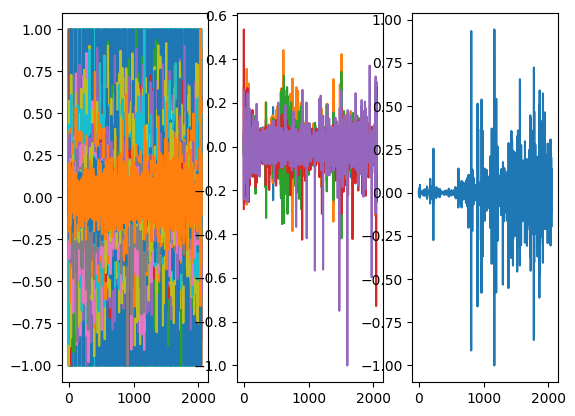

In [231]:
random.shuffle(l1)
random.shuffle(l2)
xx='etfs/'+l2[0]
df,a,b,transa,neutralized=generate(xx)
fig,ax=plt.subplots(1,3)
ax[0].plot(df)
ax[1].plot(df[:,:5])
ax[2].plot(df[:,5])
plt.show()

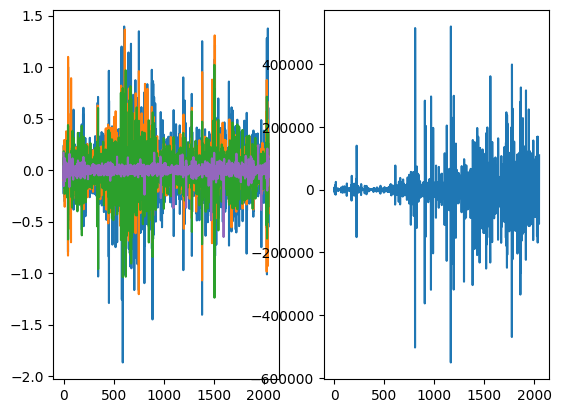

In [232]:
#restoring
def restorePreds(d,a,b,transa):
    df=d.copy()
    df[:,:5]=transa.inverse_transform(df[:,:5]*a)
    df[:,5]=df[:,5]*b
    return df
df=restorePreds(df,a,b,transa)
fig,ax=plt.subplots(1,2)
ax[0].plot(df[:,:5])
ax[1].plot(df[:,5])
plt.show()

In [233]:
def create(dataset,lb,lf=1):
    X,y=[],[]
    for i in range(len(dataset)-lb-lf+1):
        X.append(np.array(dataset[i:i+lb]))
        y.append(np.array(dataset[i+1:i+lb+lf]))
    return torch.tensor(np.array(X)).float(),torch.tensor(np.array(y)).float()

In [192]:
lb=50
X_train,y_train=create(df,lb=lb)

PHASE 1a1: LSTM PREDICTION

In [193]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm=nn.LSTM(input_size=92,hidden_size=200,num_layers=2,dropout=0.1,batch_first=True)
        self.l1=nn.Linear(200,92)
    def forward(self,x):
        x,_=self.lstm(x)
        x=self.l1(x)
        return x

In [325]:
model=LSTMModel()
model.to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3,step_size_up=10000,mode="triangular2",cycle_momentum=False)

In [326]:
def signloss(y_pred,y):
    return torch.ceil(-y_pred[:,:,:5]*y[:,:,:5])

In [327]:
def lstmloss(y_pred,y):
    return torch.clip(2*(torch.mean(torch.square(y_pred-y)*10)+torch.mean(signloss(y_pred,y)*torch.abs(y[:,:,:5]))),max=.5)

In [328]:
def train(n_epochs,dl,lf=1):
    for i in range(n_epochs):
        for X,y in dl:
            y=y.to(device)
            logits=0
            y_pred=model(X.to(device))
            logits+=lstmloss(y_pred,y[:,:lb])
            for j in range(1,lf):
                y_pred=model(y_pred)
                logits+=lstmloss(y_pred,y[:,j:j+lb])
            logits=logits/lf
            optimizer.zero_grad()
            logits.backward()
            optimizer.step()
            scheduler.step()
    print(logits)
    torch.save(model.state_dict(),'lstmmodel.pt')

In [329]:
model.train()
for i in l2[:100]:
    a='etfs/'+i
    df,_,_,_,_=generate(a)
    X_train,y_train=create(df,lb=lb)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(1,dl)

tensor(0.4960, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4916, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3302, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4428, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3723, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4338, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4608, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2906, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3487, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3463, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4426, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2615, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3620, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3383, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2670, device='cuda:0', grad_fn=<DivBack

C:\Users\reiner\AppData\Local\Temp\ipykernel_3456\3894730440.py:18: RuntimeWarning: invalid value encountered in divide
  df[:,6:] /= np.max(np.abs(df[:,6:]),0)


tensor(0.3451, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2389, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3255, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2646, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3208, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2477, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2406, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2280, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2756, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3101, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3785, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2561, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2455, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3172, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3490, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2218, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2473, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2930, device='cuda:0', grad_fn=<DivBack

PHASE 1a2: LSTM STAGE 2 (>1 PREDICTION)

In [ ]:
'''model.train()
random.shuffle(l1);random.shuffle(l2)
for i in l2[:100]:
    a='etfs/'+i
    df,_,__,___=generate(a)
    X_train,y_train=create(df,lb=lb,lf=10)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(5,dl,10)'''

"model.train()\nrandom.shuffle(l1);random.shuffle(l2)\nfor i in l2[:100]:\n    a='etfs/'+i\n    df,_,__,___=generate(a)\n    X_train,y_train=create(df,lb=lb,lf=10)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(5,dl,10)"

In [ ]:
'''random.shuffle(l1);random.shuffle(l2)
for i in l2:
    a='etfs/'+i
    df,_,__,___=generate(a)
    X_train,y_train=create(df,lb=lb,lf=50)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(5,dl,50)'''

"random.shuffle(l1);random.shuffle(l2)\nfor i in l2:\n    a='etfs/'+i\n    df,_,__,___=generate(a)\n    X_train,y_train=create(df,lb=lb,lf=50)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(5,dl,50)"

In [330]:
model.load_state_dict(torch.load('lstmmodel.pt'))

<All keys matched successfully>

In [336]:
xx='etfs/'+random.choice(l2)
print(xx)

etfs/CNCR.csv


In [337]:
model.eval() #NOT EVAL IN FINAL PREDICTIONS
df,a,b,transprices,neutralized=generate(xx)
X_test,y_test=create(df,lb=lb)
dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test,y_test),shuffle=False,batch_size=1)
qwer=True
for X,y in dl:
    if qwer:
        ggg=list(X.detach().numpy()[0])
        qwer=False
    ggg.append(model(X.to(device))[0][-1].detach().cpu().numpy())

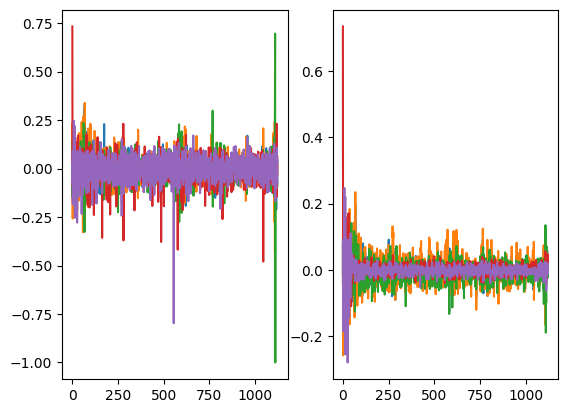

In [338]:
fig,ax=plt.subplots(1,2)
ax[0].plot(df[:,:5])
ax[1].plot(np.array(ggg)[:,:5])
plt.show()

(1124, 6)
[array([2.55499992e+01, 2.57800007e+01, 2.50699997e+01, 2.50900002e+01,
       2.46337376e+01, 4.59000000e+04])]


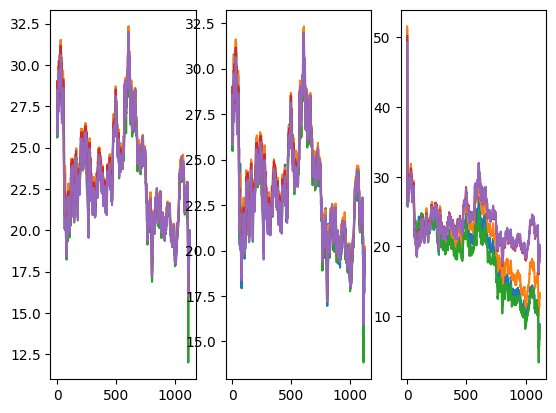

In [343]:
d2=np.array(pd.read_csv(xx).filter(['Open','High','Low','Close','Adj Close','Volume']))
print(d2.shape)
fig,ax=plt.subplots(1,3)
ax[0].plot(d2[1:,:5]) # original

ggg=np.array(ggg)
ggg1=restorePreds(ggg,a,b,transprices)
test2=d2[0:-1,:5]+ggg1[:,:5]+neutralized[1:]-neutralized[:-1]
ax[1].plot(test2[:-1]) # check that the transforms are correct, consider this 1d preds

testult=[d2[0]]
print(testult)
for i in range(ggg1.shape[0]):
    testult.append(np.sum(ggg1[:i+1],axis=0)[:6])
testult = np.array(testult)[:-1,:5]+neutralized[:-1]
ax[2].plot(np.array(testult)[:-1,:5]) # results, cumulative error

In [344]:
def test_prep(arr):
    arr /= np.max(np.abs(arr))
    arr = arr[:-1]-arr[1:]
    return arr
d2 = test_prep(d2[1:,:5]) #original
test2 = test_prep(test2) #preds

pp=np.sum(np.ceil(d2))
pn=np.sum(np.ceil(-d2))
p=np.sum(np.ceil(test2))
n=np.sum(np.ceil(-test2))
tp=np.sum(np.ceil(d2)*np.ceil(test2))
tn=np.sum(np.ceil(-d2)*np.ceil(-test2))
recall=tp/p
precision=tp/pp
print('recall: ',recall)
print('precision: ',precision)
print('acc: ',(tp+tn)/(p+n))
print('f1: ',2*recall*precision/(recall+precision))

recall:  0.8013673983447284
precision:  0.8365890308039068
acc:  0.820855614973262
f1:  0.8185995221466641


PHASE 1b1: LGBM

In [ ]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [245]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [246]:
p_data = pd.read_csv(xx).filter(['Open','High','Low','Close','Adj Close','Volume'])

In [247]:
p_data,_,_,_,_=generate(xx)
p_data = pd.DataFrame(p_data, columns = np.arange(p_data.shape[1]))
p_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
count,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,...,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000
mean,-0.000217,0.001403,-0.001405,0.000506,-0.000757,-0.000006,0.000736,0.028412,0.000930,0.000850,...,0.007497,0.004016,0.002044,-0.022326,-0.020791,-0.014910,-0.003829,-0.004588,-0.004387,0.011890
std,0.034108,0.038427,0.049904,0.032485,0.039123,0.101993,0.108887,0.145616,0.070985,0.108186,...,0.165871,0.187460,0.138780,0.103935,0.154589,0.113443,0.136899,0.127505,0.124416,0.123318
min,-0.212730,-0.245107,-1.000000,-0.292821,-0.604794,-1.000000,-1.000000,-0.902025,-0.680138,-1.000000,...,-1.000000,-0.746502,-1.000000,-1.000000,-1.000000,-1.000000,-0.602319,-1.000000,-1.000000,-0.730028
25%,-0.017876,-0.016333,-0.018380,-0.018225,-0.018032,-0.030692,-0.046632,-0.045634,-0.036061,-0.024767,...,-0.083697,-0.109290,-0.077177,-0.055138,-0.088548,-0.055346,-0.038601,-0.071325,-0.068943,-0.055097
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.017511,0.019053,0.017006,0.017161,0.017355,0.031961,0.048202,0.109458,0.038199,0.022294,...,0.089842,0.104255,0.079449,0.040343,0.082093,0.049934,0.013455,0.064464,0.062588,0.068870
max,0.183400,0.186321,0.797816,0.240823,0.230291,0.856707,0.644653,1.000000,1.000000,0.991580,...,0.983091,1.000000,0.596000,0.175950,0.287482,0.319118,1.000000,0.990678,0.991068,1.000000


In [248]:
total_start_time = time.time()

for col in p_data.columns:
    # Record start time for the column
    start_time = time.time()
    
    # Load data
    data = d2
    X = pd.DataFrame(p_data)
    y = pd.Series(p_data[col])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1,
    }

    # Train the model
    num_round = 100
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=50)])

    # Make predictions
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Record end time for the column
    end_time = time.time()
    column_runtime = end_time - start_time
    
    print(f'===== Column "{col}" =====')
    print(f'Runtime: {column_runtime:.5f}s')
    print(f'RMSE: {rmse}')

# Calculate total runtime
total_end_time = time.time()
total_runtime = total_end_time - total_start_time
print(f'\nTotal runtime: {total_runtime:.5f}s')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's rmse: 0.00437413
===== Column "0" =====
Runtime: 0.09022s
RMSE: 0.0043741321656358195
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's rmse: 0.00820757
===== Column "1" =====
Runtime: 0.08000s
RMSE: 0.008207574513181246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 0.0155829
===== Column "2" =====
Runtime: 0.07300s
RMSE: 0.015582897863847561
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.00543633
===== Column "3" =====
Runtime: 0.08300s
RMSE: 0.005436328485452929
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 0.0321036
===== Column "4" =====
Runtime: 0.08